# Exercise Session 3: Statistical Inference

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Exercise: Mass Estimation from Position Measurements in 1D Brownian Motion

A Brownian particle of mass $m_\star$ moves in one dimension in a fluid characterized by a friction coefficient $\gamma$ and a temperature $T$. Its velocity $v(t)$ can be modelled as an Ornstein-Uhlenbeck process, that is as a random variable varying in time according to the stochastic differential equation ([SDE](https://en.wikipedia.org/wiki/Stochastic_differential_equation)):
$$
m_\star \, dv(t) = - \gamma v(t) \, dt + \sqrt{2 \gamma k_B T} \, dW(t),
$$
where $k_B = 1.380649×10^{−23} \mathrm{J/K}$ is the Boltzmann constant and $W(t)$ is a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). The solution of the above SDE is a random function of time following a Gaussian distribution, which at stationarity (i.e. $t \to \infty$) becomes the well-known [Maxwell-Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution).

In practice, we are interested in a model for the position of the particle in time, since the position of the Brownian particle is what we measure directly. Assuming that the velocity is stationary, for the stochastic process above the displacement $\Delta x$ occurring in the time interval $\Delta t$ is also a random Gaussian variable, with zero mean and variance given by the formula:
$$
\mathrm{Var}\{ \Delta x \} = \sigma^2(m_\star, \gamma, T, \Delta t) =  \frac{2 k_B T}{\gamma} \biggl[ \Delta t - \frac{m_\star}{\gamma} \Bigl( 1 - e^{-\gamma \Delta t / m_\star} \Bigr) \biggr].
$$

Given these premises, in this exercise we will consider the problem of inferring the true mass $m_\star$ from a series of position measurements realized when the system is stationary, given $\gamma$ and $T$.

### Task 1: simulating the Brownian motion, i.e. generating the dataset of displacements

You observe the particle's position at equally spaced times $t_0, t_1, \dots, t_n$, with $t_i - t_{i-1} = \Delta t$. Using the following values for the parameters of the problem

In [2]:
# Parameters
m_star = 5.0e-10
gamma = 1.0e-8
temp = 300.0 # Temperature T
dt = 0.01
n = 200

simulate $n$ displacements $\Delta x_1, \dots, \Delta x_n$ as i.i.d. (independent and identically distributed) Gaussian variables with zero mean and variance $\sigma^2(m_\star, \gamma, T, \Delta t)$. Then, construct the corresponding trajectory. For simplicity, assume that $x_0 = 0$.

**1.1** Code the function $\sigma^2(m, \gamma, T, \Delta t)$.

In [3]:
def displacement_var(m, gamma, temp, dt, kB = 1.380649e-23):
    return (2 * kB * temp / gamma) * (dt - (m / gamma) * (1 - np.exp(-gamma * dt / m)))

**1.2** Write a function that takes $m$, $\gamma$, $T$, $\Delta t$ and $n$ as inputs and generates the dataset of displacements as a vector of length $n$.

In [4]:
def generate_dataset(m, gamma, temp, dt, n):
    # Compute the variance on the given parameters
    var = displacement_var(m, gamma, temp, dt)

    # Gaussian displacements
    displacements = np.random.normal(0, np.sqrt(var), size=n)
    
    return displacements

**1.3** Generate a dataset.

In [5]:
displacements = generate_dataset(m_star, gamma, temp, dt, n)

**1.4** As a sanity check, plot its histogram and the Gaussian p.d.f. $\mathcal{N}(0, \sigma^2(m_\star, \gamma, T, \Delta t))$ from which the dataset should be drawn. Use reasonable limits for the $x$-axis.

*Hint*: To plot the histogram you can use ```hist``` from ```matplotlib.pyplot``` (check [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)). Set ```density = True``` to have the histogram represent a p.d.f. (remember that large $y$-values are expected when your p.d.f. is narrow). To plot the theoretical Gaussian you can employ the function ```norm``` from ```scipy.stats```, which has already been imported at the beginning of this notebook (check [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)).

Text(0.5, 1.0, 'Histogram of Displacements')

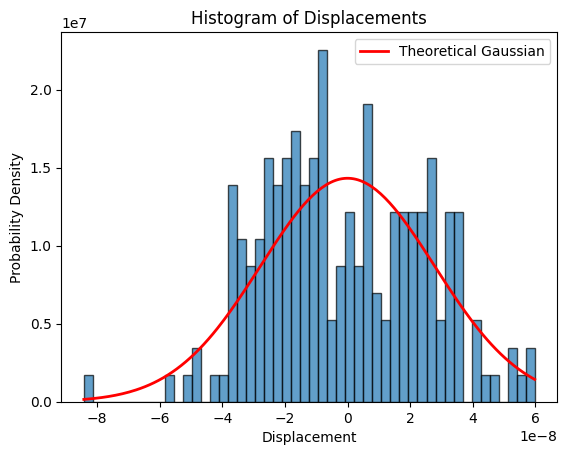

In [6]:
# Plot histogram
_, bins, _ = plt.hist(displacements, bins=50, density=True, alpha=0.7, edgecolor='black')

# Plot Gaussian curve
x = np.linspace(min(bins), max(bins), 200)
pdf = norm.pdf(x, loc=0, scale=np.sqrt(displacement_var(m_star, gamma, temp, dt)))
plt.plot(x, pdf, 'r-', lw=2, label="Theoretical Gaussian")

plt.legend()
plt.xlabel("Displacement")
plt.ylabel("Probability Density")
plt.title("Histogram of Displacements")

**1.5** Plot the trajectory corresponding to your dataset.

*Remark*: The plot will display **one realization** of the particle trajectory.

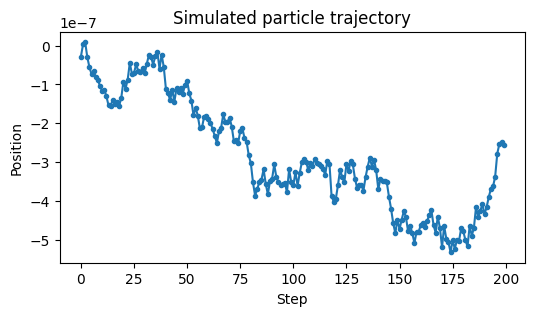

In [7]:
positions = np.cumsum(displacements) # Cumulative sum gives trajectory

# Plot
plt.figure(figsize=(6,3))
plt.plot(positions, marker='.')
plt.title('Simulated particle trajectory')
plt.xlabel('Step')
plt.ylabel('Position')
plt.show()

### Task 2: estimation of $m_\star$ through maximum likelihood

In this section, we implement the maximum likelihood estimator (MLE) for the mass, and use it to estimate $m_\star$ for the dataset that you generated.

**2.1** Prove that MLE $\hat{m}$ is the solution to the following equation
$$
\sigma^2(\hat{m}, \gamma, T, \Delta t) = S_n^2
$$
where $S_n^2 = \frac{1}{n} \sum_{i = 1}^n (\Delta x_i)^2$ is the (biased) estimator for the variance.

*Hint*: It is useful to maximise the log-likelihood instead of the likelihood to convert products into sums (recall that logs do not alter the position of maxima).

**Solution**

Let us call $\sigma^2(m) = \sigma^2(m, \gamma, T, \Delta t)$ by an abuse of notation. The likelihood for the independent Gaussian displacements $\{ \Delta x_i \}_{i = 1}^n$ is
$$
L(m; \{\Delta x_i\}_{i=1}^n) = P(\{\Delta x_i\}_{i=1}^n | m) = \prod_{i = 1}^n \frac{1}{\sqrt{2 \pi \sigma^2(m)}} e^{- \frac{(\Delta x_i)^2}{2 \sigma^2(m)}}.
$$

The log-likelihood is
$$
\ell(m; \{\Delta x_i\}_{i=1}^n) = \log P(\{\Delta x_i\}_{i=1}^n | m) = -\frac{n}{2} \log(2 \pi \sigma^2(m)) - \frac{1}{2\sigma^2(m)} \sum_{i = 1}^n (\Delta x_i)^2.
$$

Differentiating w.r.t. $m$ and setting the derivative to 0 yields:
$$
\frac{d \sigma^2(m)}{d m} \biggl[ - \frac{n}{2 \sigma^2(m)} + \frac{1}{2 \sigma^4(m)} \sum_{i = 1}^n (\Delta x_i)^2 \biggr] = 0.
$$

Since $\frac{d \sigma^2(m)}{dm} \neq 0$, the term in brackets must vanish:
$$
\sigma^2(m) = \frac{1}{n} \sum_{i=1}^n (\Delta x_i)^2
$$
or equivalently:
$$
\sigma^2(m) = S_n^2.
$$

Thus, the MLE $\hat{m}$ solves this equation.

**2.2** Show that the previous equation can be cast as a fixed-point equation in $\hat{m}$, i.e. an equation of the form $\hat{m} = F(\hat{m})$, with $F$ to be determined.

**Solution**

Rearranging the equation for the MLE we obtain:
$$
m = \frac{\gamma \Bigl( \Delta t - \frac{\gamma S_n^2}{2 k_B T} \Bigr)}{1 - e^{- \gamma \Delta t / m}}.
$$
Therefore, $F(m) = \frac{\gamma \Bigl( \Delta t - \frac{\gamma S_n^2}{2 k_B T} \Bigr)}{1 - e^{- \gamma \Delta t / m}}$.

*Remark*: **What is the fixed-point iteration method?**

The fixed-point iteration method is a simple numerical technique to solve equations of the form $x = F(x)$. The idea is:
1. Start with an initial guess $x_0$.
2. Compute a new value by plugging into the function: $x_{k+1} = F(x_k)$.
3. Repeat until the sequence $\{ x_k \}$ stops changing (converges).

In particular, regarding point 3., one usually needs to define a convergence criterion. A standard choice is to compute at each step the absolute difference $|x_{k+1} - x_{k}|$ and to claim convergence when this is smaller than a conventionally small enough tolerance. Then, $x_{k+1}$ is taken as the approximate solution to the fixed-point equation.

However, convergence is not always guaranteed. If the function $F(x)$ is well-behaved (specifically, if $|F'(x)| < 1$ near the solution), then the iteration will converge to the fixed point $x^*$ that satisfies $x^* = F(x^*)$.

In our problem, the MLE equation for $\hat{m}$ cannot be solved in closed form, but we were able to rewrite it as a fixed-point equation. This allows us to approximate $\hat{m}$ by repeatedly applying $F$ until the value stabilizes.

**2.3** Assuming that $F(m)$ is well-behaved, write a function that computes the fixed point of the above equation using the fixed-point iteration method.

*Hint*: A proper function must have an optional initial value for the mass, an optional value for the tolerance and an optional maximum number of iterations (for safety). Additionally, in the case of no convergence, it should raise an error or simply return ```None``` after printing a warning message.

In [8]:
def fixed_point_estimator(displacements, gamma, temp, dt, kB=1.380649e-23, m0=1, tol=1e-12, max_iter=1000):
    """
    Computes the fixed point solution for m using fixed-point iteration.
    """

    Sn2 = np.mean(displacements**2)
    
    def F(m):
        return (gamma * (dt - gamma * Sn2 / (2 * kB * temp))) / (1 - np.exp(-gamma * dt / m))
    
    m = m0
    for _ in range(max_iter):
        m_new = F(m)
        if abs(m_new - m) < tol:
            return m_new
        m = m_new
    raise RuntimeError("Fixed point iteration did not converge")

**2.4** Compute $\hat{m}$ (via fixed-point iteration) on the dataset that you generated. Then plot the log-likelihood of your dataset as a function of the parameter $m$ together with the two vertical lines $m = \hat{m}$ and $m = m_\star$. Add a legend for clarity.

*Hint*: Take a reasonable initial value for $m$ (that means positive). Play with the tolerance value and the maximum number of iterations in your fixed-point iteration in order to get the best approximation of the MLE. Use a log scale for the $x$-axis. It is helpful to use different line-styles for the two vertical lines.

*Remark*: Again, the point that you obtain via fixed-point iteration is an **approximation** for the point maximizing the (log-)likelihood, namely the MLE. The latter in turn is what we use to estimate the ground-truth value of the mass. In general, there is no reason to expect the MLE to give a "very good" estimate of the true parameter (we will come back to this point in the last task of the exercise).

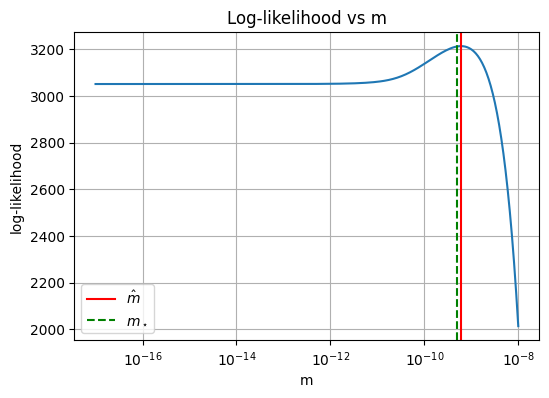

In [9]:
m_hat = fixed_point_estimator(displacements, gamma, temp, dt)

def log_likelihood(m, displacements, gamma, temp, dt, kB=1.380649e-23):
    var = displacement_var(m, gamma, temp, dt, kB)
    n = len(displacements)
    return -0.5 * n * np.log(2 * np.pi * var) - 0.5 * np.sum(displacements**2) / var

ms = np.logspace(-17, -8, 200)
lls = [log_likelihood(m, displacements, gamma, temp, dt) for m in ms]

plt.figure(figsize=(6,4))
plt.plot(ms, lls)
plt.xscale('log')
plt.xlabel("m")
plt.ylabel("log-likelihood")
plt.title("Log-likelihood vs m")
plt.axvline(m_hat, color='r', linestyle='-', label=r"$\hat m$")
plt.axvline(m_star, color='g', linestyle='--', label=r"$m_\star$")
plt.legend()
plt.grid()

### Task 3: likelihood flattening in the diffusive regime

For an Ornstein-Uhlenbeck velocity process we can distinguish two interesting regimes:
- If $\gamma \Delta t / m_\star << 1$, the motion is *ballistic* (dominated by inertia).
- If $\gamma \Delta t / m_\star >> 1$, the motion is *diffusive* (dominated by diffusion).

**3.1** Check that the values for $m_\star$, $\gamma$ and $\Delta t$ considered until now do <u>not</u> correspond to a diffusive regime.

In [10]:
gamma * dt / m_star

0.19999999999999998

**3.2** Replace the previously employed value for $m_\star$ with

In [11]:
m_star2 = 5.0e-15

and repeat the same check. Are you still out of the diffusive regime with this new value of $m_\star$?

In [12]:
gamma * dt / m_star2

20000.0

**3.3** Using the same $\gamma$, $T$, $\Delta t$ and $n$ as before, generate a dataset of displacements using the new value for the ground-truth mass. Then plot the corresponding log-likelihood as a function of $m$. Do you observe any difference w.r.t. the last plot? Is maximizing the (log-)likelihood still a reasonable approach in this situation?

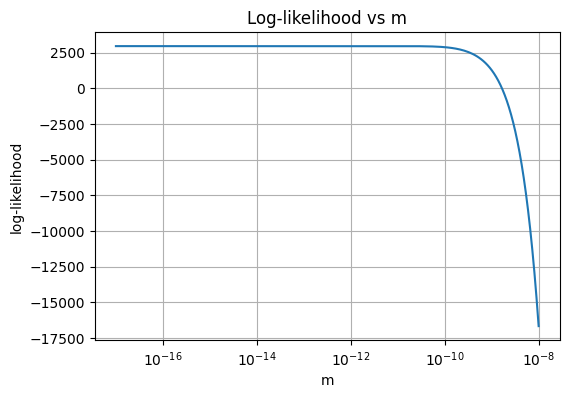

In [13]:
displacements2 = generate_dataset(m_star2, gamma, temp, dt, n)

ms = np.logspace(-17, -8, 200)
lls2 = [log_likelihood(m, displacements2, gamma, temp, dt) for m in ms]

plt.figure(figsize=(6,4))
plt.plot(ms, lls2)
plt.xscale('log')
plt.xlabel("m")
plt.ylabel("log-likelihood")
plt.title("Log-likelihood vs m")
plt.grid()

**3.4** Compute (via fixed-point iteration) the MLE on the dataset generated with the new value of $m_\star$. Play with the tolerance value and the maximum number of iterations. Are you able to obtain a reasonable estimate, that is of the same order of magnitude of the true value?

In [14]:
fixed_point_estimator(displacements2, gamma, temp, dt, tol=1e-15)

RuntimeError: Fixed point iteration did not converge

**3.5** Find an explanation for the results that you have just found.

*Hint*: One way is to rewrite $\sigma^2(m_\star, \gamma, T, \Delta t)$ for $\gamma \Delta t / m_\star >> 1$.

**Solution**

First, rewrite $\sigma^2(m_\star, \gamma, T, \Delta t)$ as follows:
$$
\sigma^2(m_\star, \gamma, T, \Delta t) = \frac{2 k_B T \Delta t}{\gamma} \biggl[ 1 - \frac{m_\star}{\gamma \Delta t} \Bigl( 1 - e^{-\gamma \Delta t / m_\star} \Bigr) \biggr].
$$
Next, for $\gamma \Delta t / m_\star >> 1$:
$$
\sigma^2(m_\star, \gamma, T, \Delta t) \simeq \frac{2 k_B T \Delta t}{\gamma} \biggl[ 1 - \frac{m_\star}{\gamma \Delta t} \biggr] = \frac{2 k_B T \Delta t}{\gamma} - \frac{2 k_B T \Delta t}{\gamma} \frac{m_\star}{\gamma \Delta t}.
$$
In the exact limit $m_\star / \gamma \Delta t \to 0$ the displacement variance becomes independent of the mass: the motion of the particle is given by pure diffusion. In particular, this implies that the true mass becomes unidentifiable from position data alone. This basically holds also when $m_\star / \gamma \Delta t$ is not zero, but is nonetheless very, very small.

Following the same reasoning, the log-likelihood flattens in the diffusive regime because the displacement variance $\sigma^2(m, \gamma, T, \Delta t)$ saturates to a constant independent of the mass. The likelihood therefore becomes nearly flat: all values of $m$ <u>in the diffusive regime</u> explain the data equally well.

### Task 4: dependence on the dataset size

Let's return to the initial setting of parameters. What happens if we have a small number of observations?

**4.1** Generate a dataset of size $n = 20$.

In [15]:
n_small = 20
displacements3 = generate_dataset(m_star, gamma, temp, dt, n_small)

**4.2** Repeat task 2.4 on this new dataset. What happens to the MLE?

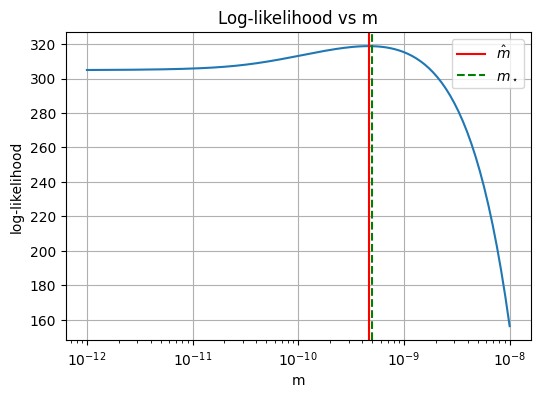

In [16]:
m_hat = fixed_point_estimator(displacements3, gamma, temp, dt)

ms = np.logspace(-12, -8, 200)
lls = [log_likelihood(m, displacements3, gamma, temp, dt) for m in ms]

plt.figure(figsize=(6,4))
plt.plot(ms, lls)
plt.xscale('log')
plt.xlabel("m")
plt.ylabel("log-likelihood")
plt.title("Log-likelihood vs m")
plt.axvline(m_hat, color='r', linestyle='-', label=r"$\hat m$")
plt.axvline(m_star, color='g', linestyle='--', label=r"$m_\star$")
plt.legend()
plt.grid()

**4.3** Find an explanation for the results that you have just found.

*Hint*: The law of large numbers is involved.

**Solution**

We have seen that the MLE $\hat{m}$ satisfies the equation $\sigma^2(\hat{m}) = S_n^2$, where $S_n^2$ is the (biased) variance estimator.

Now, by the law of large numbers, when $n$ is sufficiently large $S_n^2$ converges to the variance of the ground-truth distribution, namely $\sigma^2(m_\star)$. Thus, the condition for the MLE requires $\sigma^2(\hat{m}) = \sigma^2(m_\star)$, that is $\hat{m} = m_\star$. For instance, this occurs with the value of $n$ with which you started the exercise, as you have seen in the second task.

However, when $n$ is finite, the law of large numbers does not apply and $S_n^2 \neq \sigma^2(m_\star)$. Therefore, in this scenario the MLE $\hat{m}$ will differ from $m_\star$.